In [128]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2, chi2_contingency
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

In [129]:
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
data_dir = os.path.join(root_dir, 'data')
data_file_path = os.path.join(data_dir, 'breast_cancer_data.csv')

df_breast_cancer = pd.read_csv(data_file_path, sep=",", header=0)

# Eliminar espacios adicionales en los nombres de columnas
df_breast_cancer.columns = df_breast_cancer.columns.str.strip()
# Corregir el nombre de 'Reginol Node Positive'
df_breast_cancer.rename(columns={'Reginol Node Positive': 'Regional Node Positive'}, inplace=True)


# EDA (Exploratory Data Analysis)

In [130]:
df_breast_cancer.dtypes

Age                        int64
Race                      object
Marital Status            object
T Stage                   object
N Stage                   object
6th Stage                 object
differentiate             object
Grade                     object
A Stage                   object
Tumor Size                 int64
Estrogen Status           object
Progesterone Status       object
Regional Node Examined     int64
Regional Node Positive     int64
Survival Months            int64
Status                    object
dtype: object

In [131]:
# Missings
df_breast_cancer.isna().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Regional Node Positive    0
Survival Months           0
Status                    0
dtype: int64

We remove the `Grade` variable as it gives the same information as the `differentiate`variable.

In [132]:
df_breast_cancer = df_breast_cancer.drop(columns=['Grade'])

## Univariate Analysis

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math

def analyze_univariate(df, column_name, axes, idx):
    if df[column_name].dtype in ['int64', 'float64']:
        # Summary statistics
        stats = df[column_name].describe()
        iqr = stats['75%'] - stats['25%'] 

        # Mild Outliers
        mild_ub = stats['75%'] + 1.5 * iqr
        mild_lb = max(stats['25%'] - 1.5 * iqr, 0)

        mild_outliers = np.sum((df[column_name] > mild_ub) | (df[column_name] < mild_lb))
        print("Number of mild outliers in " + column_name + ": ", mild_outliers)

        # Severe Outliers
        severe_ub = stats['75%'] + 3 * iqr
        severe_lb = max(stats['25%'] - 3 * iqr, 0)
        severe_outliers = np.sum((df[column_name] > severe_ub) | (df[column_name] < severe_lb))
        print("Number of severe outliers in " + column_name + ": ", severe_outliers)

        if severe_outliers > 0:
            severe_outlier = df[(df[column_name] > severe_ub) | (df[column_name] < severe_lb)]
            severe_outlier = severe_outlier.sort_values(by=column_name, ascending=False)
            print("\nThe first 5 largest severe outliers in " + column_name + ":")
            print(severe_outlier.head(5))

        # Boxplot
        sns.boxplot(x=df[column_name], ax=axes[idx])
        axes[idx].set_title(f"Boxplot of {column_name}")
        axes[idx].axvline(x=mild_ub, color='orange', linewidth=2, label='Mild Outlier')
        axes[idx].axvline(x=mild_lb, color='orange', linewidth=2)
        axes[idx].axvline(x=severe_ub, color='red', linewidth=2, label='Severe Outlier')
        axes[idx].axvline(x=severe_lb, color='red', linewidth=2)
        axes[idx].legend()

        # Histogram
        sns.histplot(df[column_name], bins=25, kde=True, ax=axes[idx + 1])
        axes[idx + 1].set_title(f"Histogram of {column_name}")

    else:
        # Categorical Data Histogram
        if column_name == 'differentiate':
            df[column_name] = df[column_name].replace({"Well differentiated": 'well diff', "Moderately differentiated": 'mod diff', 
                                            "Poorly differentiated": 'poor diff', "Undifferentiated": 'undiff'})
        sns.histplot(data=df, x=column_name, discrete=True, ax=axes[idx])
        axes[idx].set_title(f"Distribution of {column_name}")
        axes[idx].tick_params(axis='x', rotation=45)


# Plot all columns in one figure
def plot_all_columns(df):
    num_numerical = df.select_dtypes(include=['int64', 'float64']).shape[1] - 1
    num_categorical = df.select_dtypes(exclude=['int64', 'float64']).shape[1]
    
    total_plots = num_numerical * 2 + num_categorical
    rows = math.ceil(total_plots / 4)
    
    fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    axes = axes.flatten()

    idx = 0
    for col in df.columns:
        if col != 'sev_univar_outlier':
            if df[col].dtype in ['int64', 'float64']:
                analyze_univariate(df, col, axes, idx)
                idx += 2  # Increment by 2 for both boxplot and histogram
            else:
                analyze_univariate(df, col, axes, idx)
                idx += 1  # Increment by 1 for categorical columns

    # Hide unused subplots
    for j in range(idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    # Saving the plot
    plot_path = os.path.join(os.pardir, 'plots', 'univ_analysis.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()

Number of mild outliers in Age:  0
Number of severe outliers in Age:  0
Number of mild outliers in Tumor Size:  222
Number of severe outliers in Tumor Size:  39

The first 5 largest severe outliers in Tumor Size:
      Age   Race Marital Status T Stage N Stage 6th Stage differentiate  \
3965   47  White        Married      T3      N2      IIIA     well diff   
289    41  White        Married      T3      N3      IIIC     poor diff   
1007   60  White       Divorced      T3      N2      IIIA      mod diff   
740    49  White        Married      T3      N1      IIIA      mod diff   
1512   63  White        Married      T4      N2      IIIB      mod diff   

       A Stage  Tumor Size Estrogen Status Progesterone Status  \
3965  Regional         140        Positive            Positive   
289   Regional         140        Positive            Positive   
1007  Regional         140        Positive            Positive   
740   Regional         140        Positive            Positive   
1512  

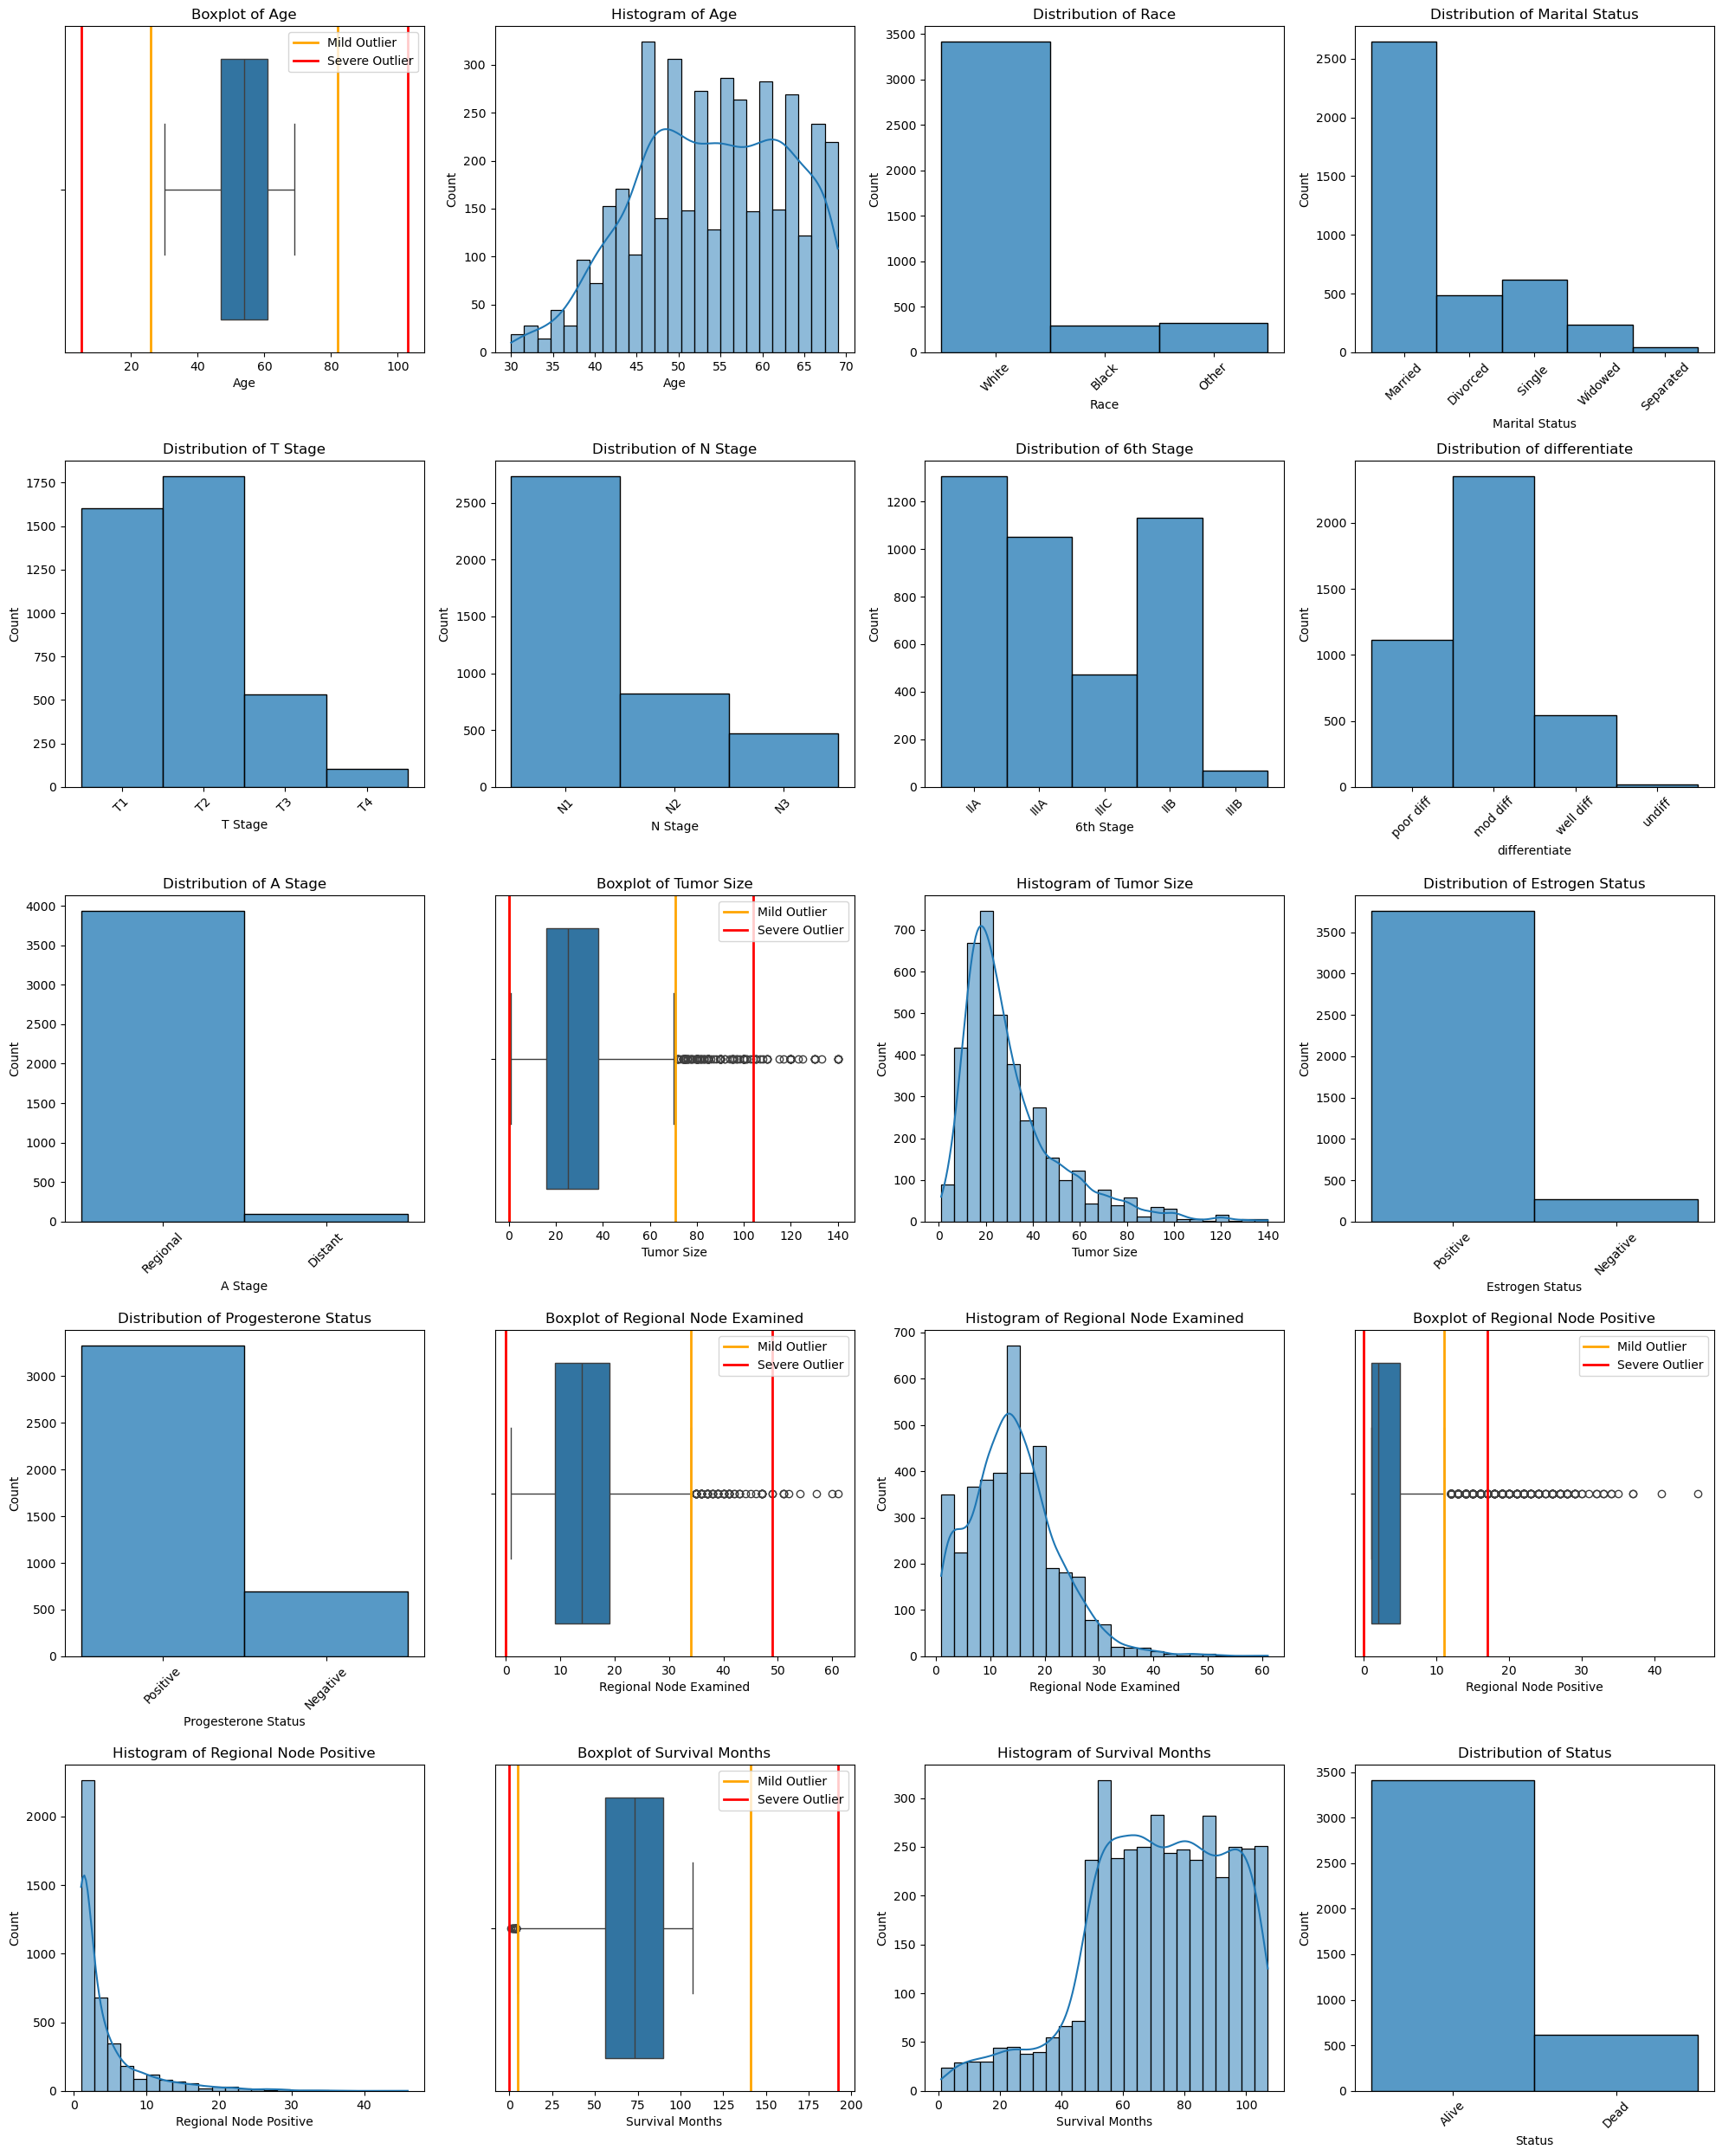

In [134]:
df_breast_cancer["sev_univar_outlier"] = 0
plot_all_columns(df_breast_cancer)

In [135]:
print(df_breast_cancer[df_breast_cancer["sev_univar_outlier"] > 1])

Empty DataFrame
Columns: [Age, Race, Marital Status, T Stage, N Stage, 6th Stage, differentiate, A Stage, Tumor Size, Estrogen Status, Progesterone Status, Regional Node Examined, Regional Node Positive, Survival Months, Status, sev_univar_outlier]
Index: []


In [136]:
df_breast_cancer = df_breast_cancer.drop(columns=['sev_univar_outlier'])

In [137]:
df_breast_cancer[df_breast_cancer['Survival Months'] < 5]

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
414,55,White,Married,T1,N1,IIA,mod diff,Regional,15,Positive,Positive,9,1,3,Alive
679,62,White,Married,T2,N2,IIIA,mod diff,Regional,25,Positive,Positive,13,4,4,Dead
721,49,White,Married,T2,N3,IIIC,mod diff,Regional,32,Positive,Positive,20,11,3,Alive
896,67,White,Married,T3,N2,IIIA,poor diff,Regional,55,Positive,Positive,9,9,4,Dead
921,43,Other,Married,T2,N3,IIIC,mod diff,Regional,40,Positive,Positive,19,11,1,Alive
928,64,White,Single,T2,N1,IIB,mod diff,Regional,22,Positive,Positive,1,1,3,Dead
1042,64,White,Divorced,T2,N2,IIIA,mod diff,Regional,25,Positive,Positive,9,4,4,Dead
1156,67,White,Married,T2,N1,IIB,poor diff,Regional,25,Positive,Positive,4,1,2,Dead
1702,59,White,Single,T3,N1,IIIA,mod diff,Regional,70,Positive,Positive,9,1,4,Dead
1709,63,White,Married,T2,N2,IIIA,mod diff,Regional,35,Positive,Positive,21,5,3,Dead


## Bivariate Analysis

In [138]:
def bivariate_numerical(df):
    target_variable = 'Status'
    num_vars = df.select_dtypes(include=['int64', 'float64']).columns

    # Pairplot
    pairplot = sns.pairplot(df[num_vars.tolist() + [target_variable]], hue=target_variable)
    
    # Save the pairplot
    pairplot_path = os.path.join(os.pardir, 'plots', 'pairplot_biv_num_analysis.png')
    pairplot.savefig(pairplot_path, dpi=300)
    plt.show()
    plt.close(pairplot.fig)  # Close pairplot to free memory

    # Melt data for boxplot
    df_melted = df.melt(id_vars=target_variable, value_vars=num_vars)

    # Create box plot
    boxplot = sns.catplot(
        x='variable', 
        y='value', 
        hue=target_variable, 
        kind='box', 
        data=df_melted, 
        height=6, 
        aspect=2
    )

    plt.xticks(rotation=45)

    # Save the boxplot
    boxplot_path = os.path.join(os.pardir, 'plots', 'boxplot_biv_num_analysis.png')
    boxplot.savefig(boxplot_path, dpi=300)
    plt.show()
    plt.close(boxplot.fig)

def bivariate_categorical(df):
    target_variable = 'Status'
    cat_vars = df.select_dtypes(include=['object']).columns
    
    # drop status
    cat_vars = cat_vars.drop('Status')
    
    num_plots = len(cat_vars)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots - 1) // num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()
    
    for i, cat_var in enumerate(cat_vars):
        if cat_var == 'differentiate':
            df[cat_var] = df[cat_var].replace({"Well differentiated": 'well diff', "Moderately differentiated": 'mod diff', 
                                            "Poorly differentiated": 'poor diff', "Undifferentiated": 'undiff'})
        # Calculate proportions for each category ensuring the sum is 100%
        cat_var_positive = df[df[target_variable] == 'Alive'][cat_var].value_counts(normalize=True) * 100
        cat_var_negative = df[df[target_variable] == 'Dead'][cat_var].value_counts(normalize=True) * 100
        cat_var_positive /= cat_var_positive.sum() / 100
        cat_var_negative /= cat_var_negative.sum() / 100
        classes = pd.Series(df[cat_var].unique())
        
        ax = axes[i]
        index = np.arange(len(classes))
        width = 0.35
        ax.bar(index, cat_var_positive, width, label='Alive')
        ax.bar(index + width, cat_var_negative, width, label='Dead')
        ax.set_xlabel(cat_var)
        ax.set_ylabel('Percentage')
        ax.set_title(f'{cat_var} vs {target_variable}')
        ax.set_xticks(index + width / 2)
        ax.set_xticklabels(classes)
        ax.legend()

    # Hide empty subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    # Saving the plot
    plot_path = os.path.join(os.pardir, 'plots', 'biv_cat_analysis.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()

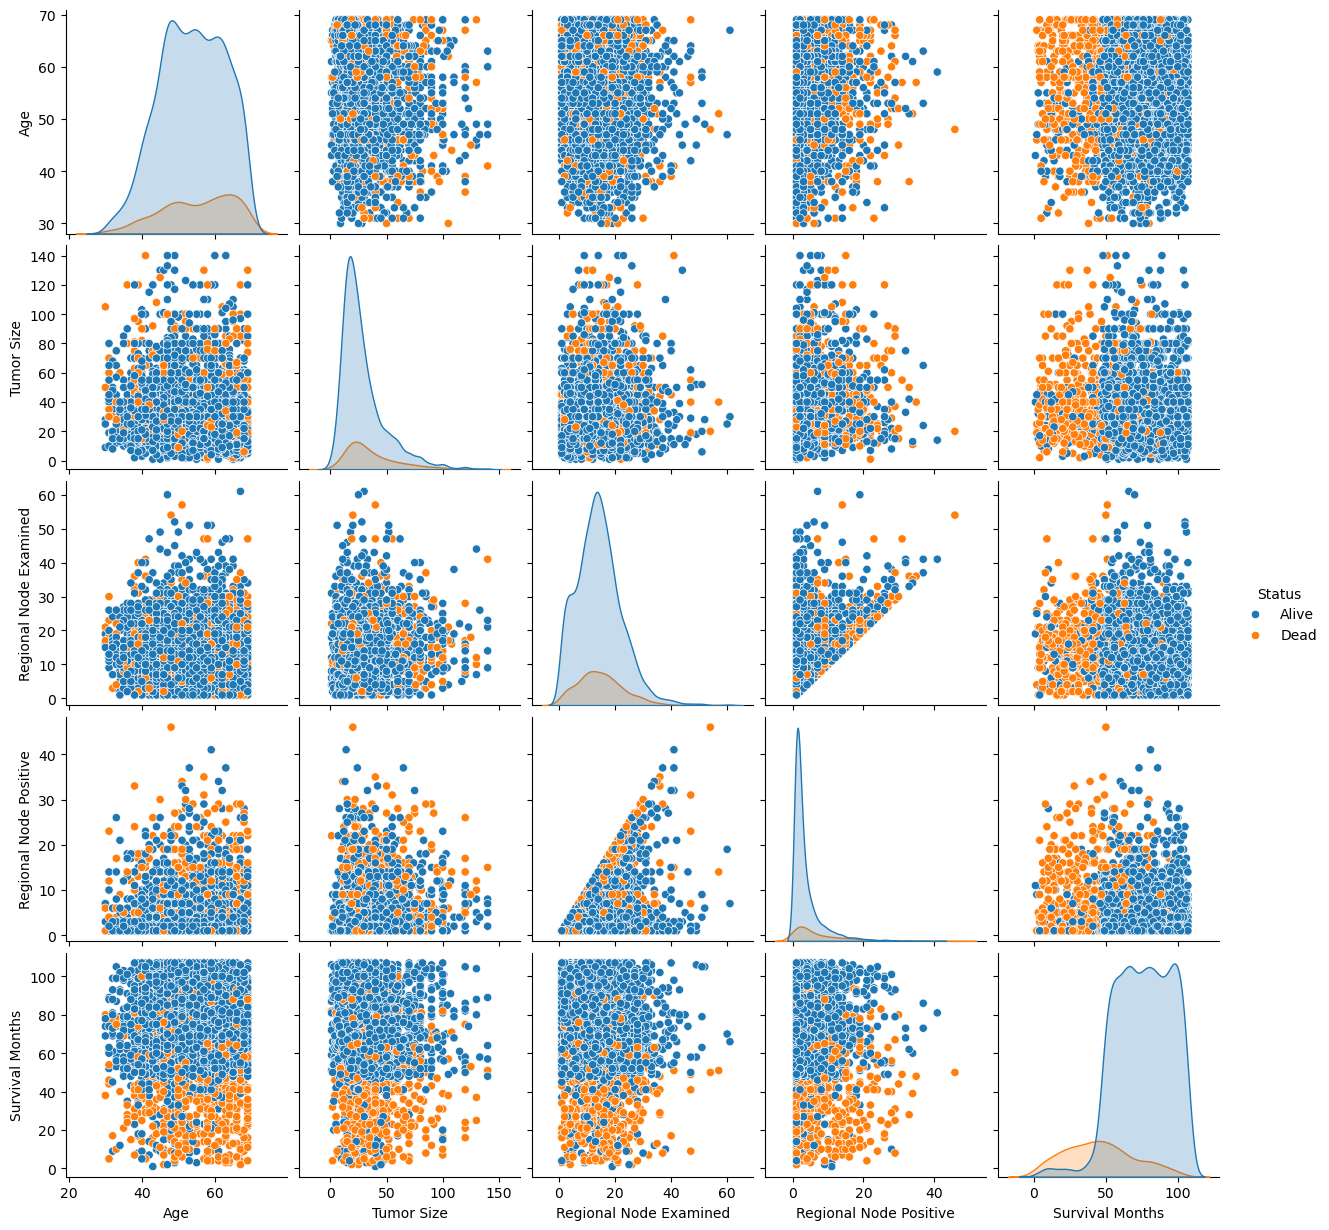

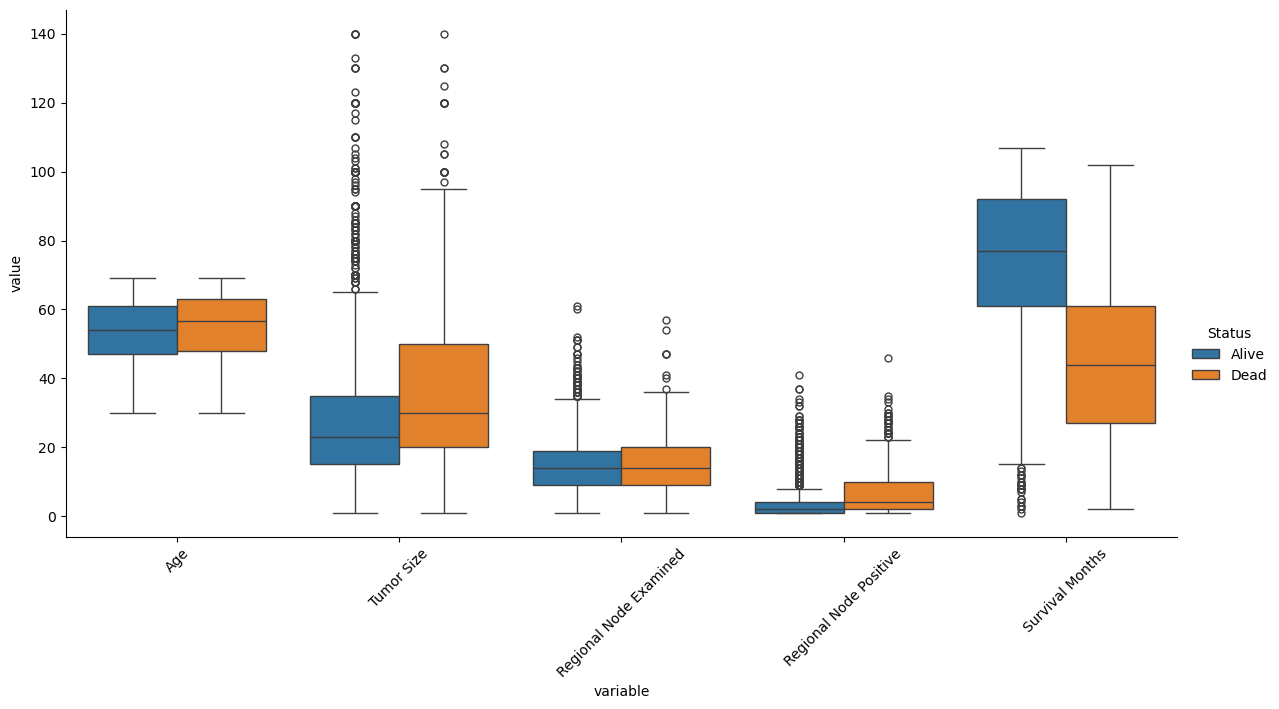

In [139]:
bivariate_numerical(
    df_breast_cancer[['Age', 'Tumor Size', 'Regional Node Examined', 
                      'Regional Node Positive', 'Survival Months', 'Status']]
)

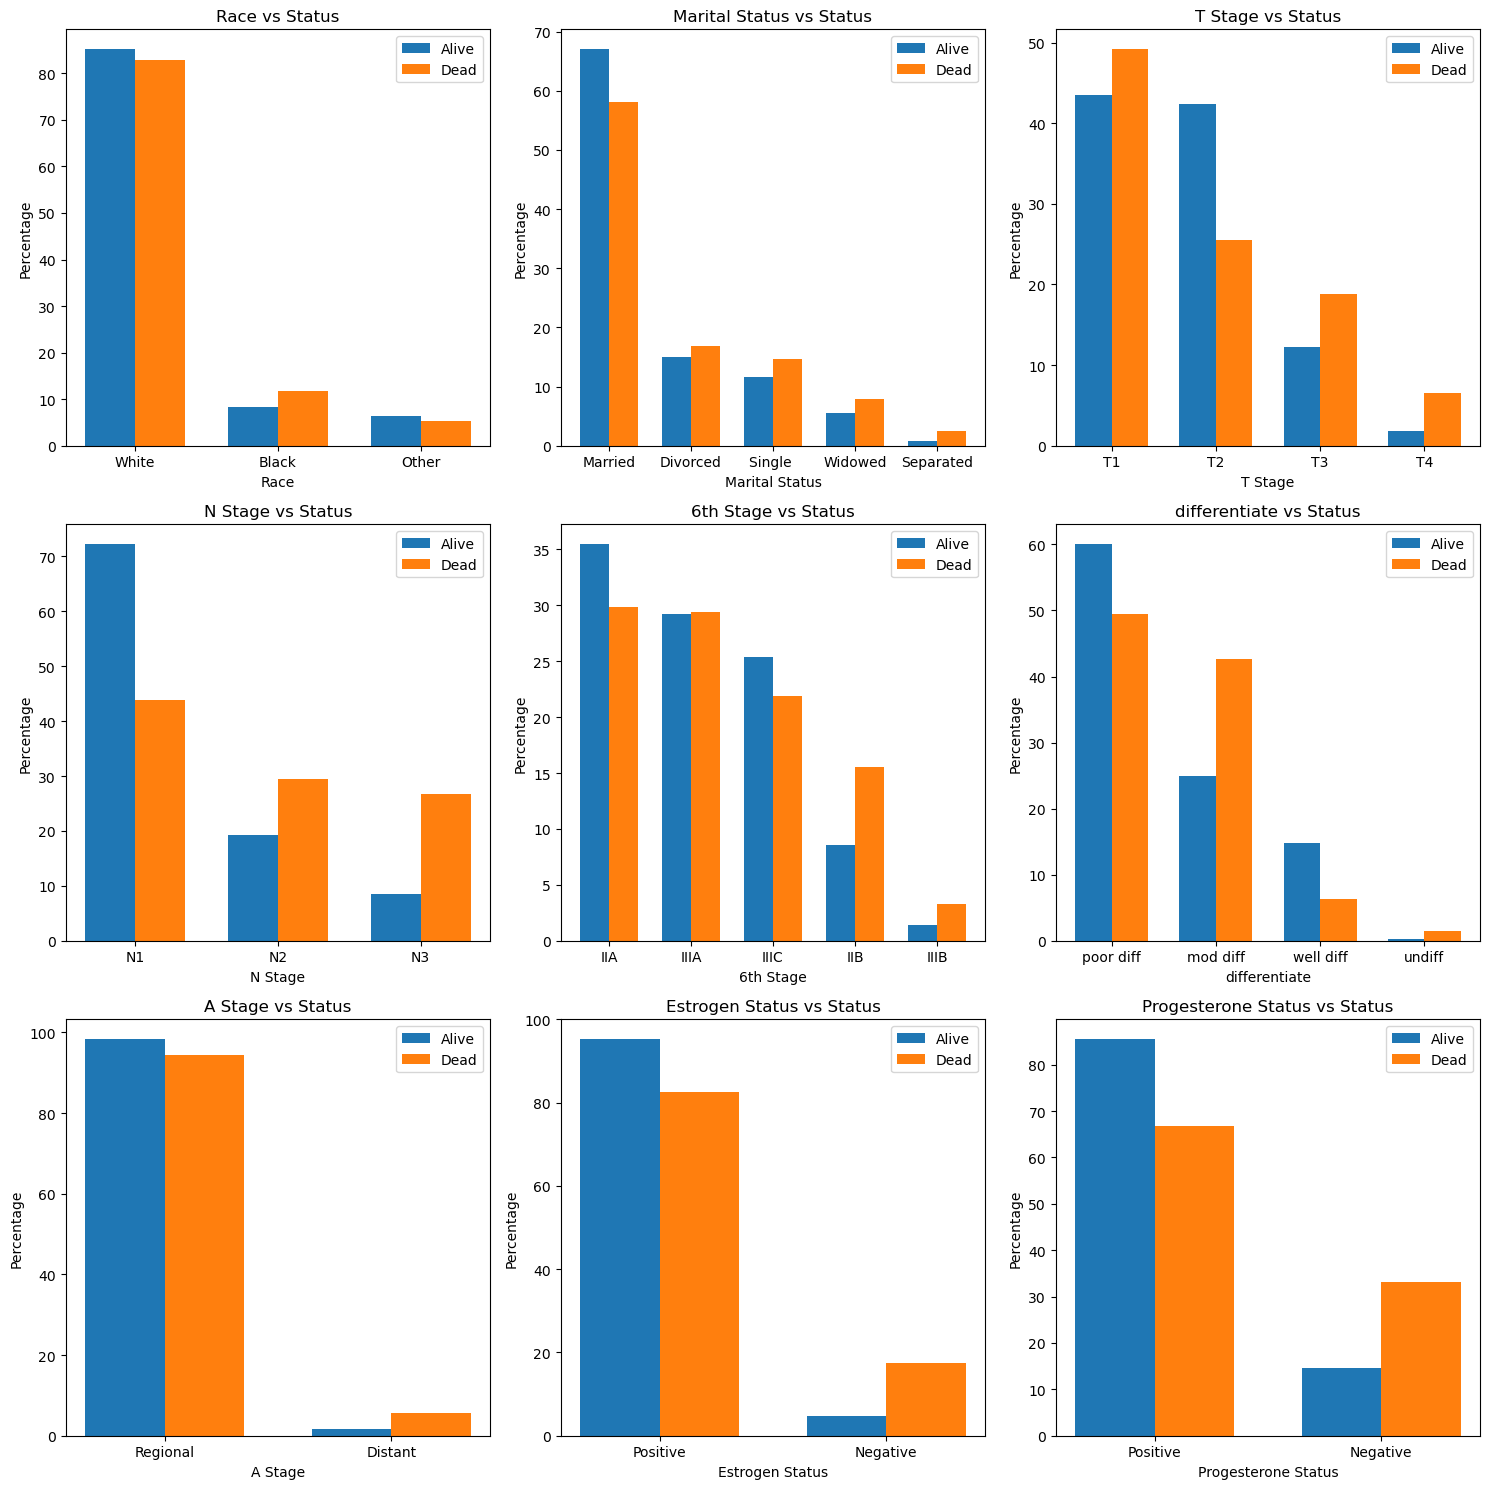

In [140]:
bivariate_categorical(df_breast_cancer)

## Multivariate Outliers

      Age   Race Marital Status T Stage N Stage 6th Stage differentiate  \
8      40  White       Divorced      T4      N3      IIIC     poor diff   
24     62  White        Married      T1      N3      IIIC     poor diff   
26     48  White        Married      T2      N3      IIIC     poor diff   
52     60  Black        Married      T3      N1      IIIA     poor diff   
57     50  White        Married      T1      N1       IIA      mod diff   
...   ...    ...            ...     ...     ...       ...           ...   
3950   47  White        Married      T2      N3      IIIC      mod diff   
3960   58  Other        Single       T2      N3      IIIC      mod diff   
3965   47  White        Married      T3      N2      IIIA     well diff   
3990   61  White        Married      T2      N1       IIB      mod diff   
4009   53  White       Divorced      T3      N1      IIIA      mod diff   

       A Stage  Tumor Size Estrogen Status Progesterone Status  \
8     Regional         103       

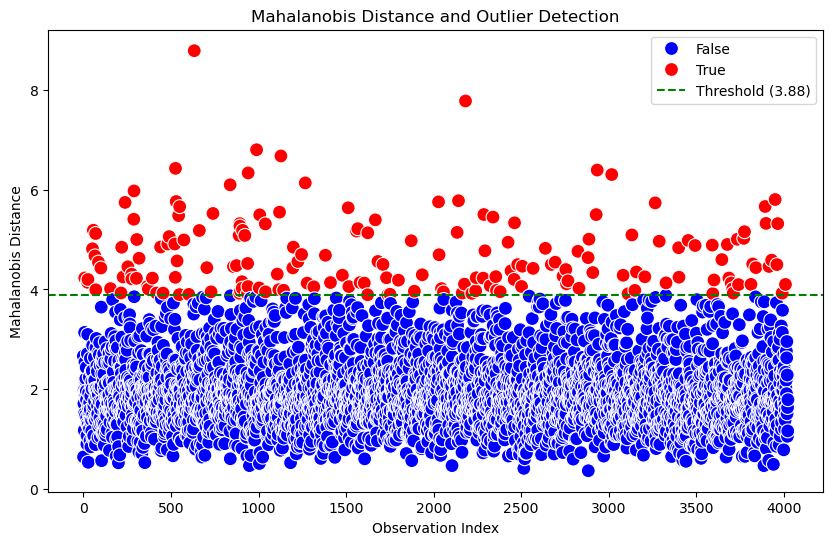

In [141]:
def calculate_mahalanobis(df):
    # Compute the mean and covariance matrix
    mean_vector = df.mean(axis=0)
    cov_matrix = np.cov(df.values.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Calculate Mahalanobis distance for each observation
    mahalanobis_distances = df.apply(lambda x: mahalanobis(x, mean_vector, inv_cov_matrix), axis=1)
    return mahalanobis_distances

def detect_multivariate_outliers(df, threshold):
    # Compute Mahalanobis distance
    distances = calculate_mahalanobis(df)
    # Identify outliers
    outliers = distances > threshold
    
    return distances, outliers

df_num = df_breast_cancer[['Age', 'Tumor Size', 'Regional Node Examined', 
                      'Regional Node Positive', 'Survival Months']]
alpha=0.01
threshold = np.sqrt(chi2.ppf((1 - alpha), df_num.shape[1]))

distances, outliers = detect_multivariate_outliers(df_num, threshold)

df_breast_cancer['Mahalanobis_Distance'] = distances
df_breast_cancer['Outlier'] = outliers

print(df_breast_cancer[df_breast_cancer['Outlier'] == True])

# Plot the Mahalanobis distances
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_breast_cancer.index, y='Mahalanobis_Distance', hue='Outlier', palette={True: 'red', False: 'blue'}, data=df_breast_cancer, s=100)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title('Mahalanobis Distance and Outlier Detection')
plt.xlabel('Observation Index')
plt.ylabel('Mahalanobis Distance')
plt.legend()
plt.show()

## Feature Selection

In [142]:
categories = [
    ['T1', 'T2', 'T3', 'T4'],  # T Stage order
    ['N1', 'N2', 'N3'],        # N Stage order
    ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC'],  # 6th Stage order
    ['well diff', 'mod diff', 'poor diff', 'undiff'],  # Differentiate order
    ['Dead', 'Alive'] # Status order
]

encoder = OrdinalEncoder(categories=categories)

df_breast_cancer[['T Stage', 'N Stage', '6th Stage', 'differentiate', 'Status']] = encoder.fit_transform(
    df_breast_cancer[['T Stage', 'N Stage', '6th Stage', 'differentiate', 'Status']]
)

### Numerical Analysis

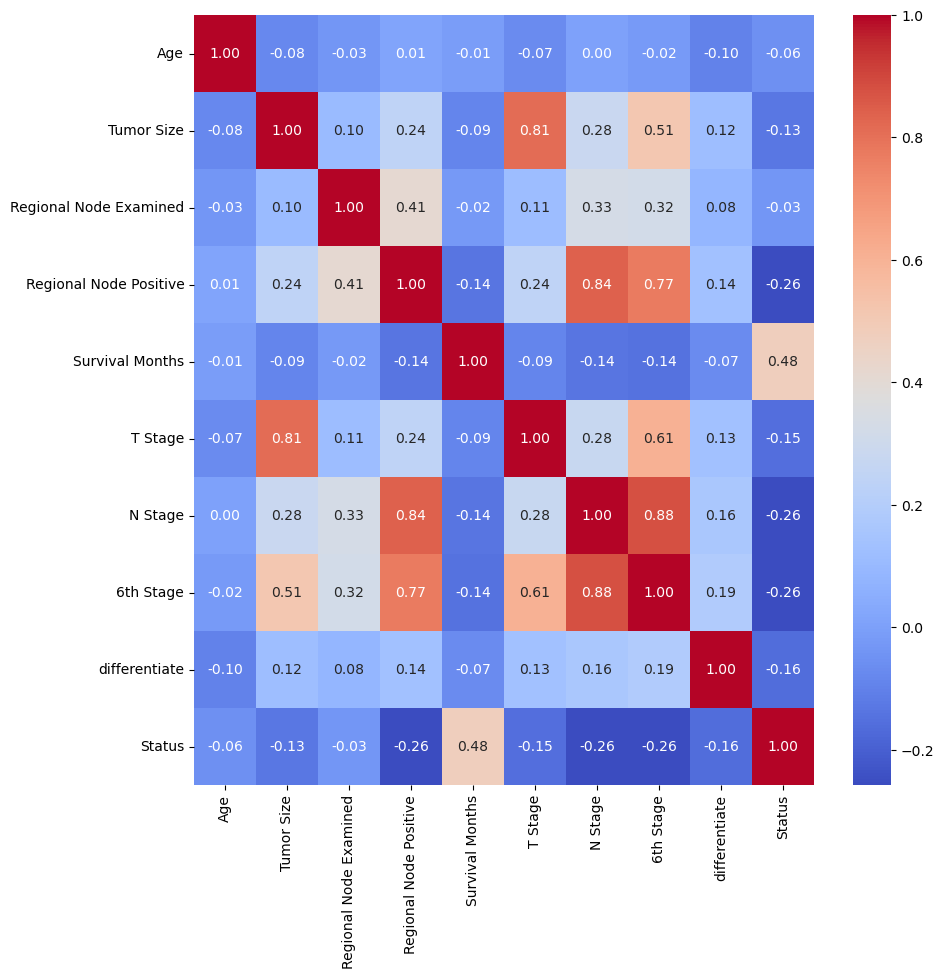

In [143]:
# List of numerical columns
num_cols = ['Age', 'Tumor Size', 'Regional Node Examined', 
            'Regional Node Positive', 'Survival Months', 'T Stage', 
            'N Stage', '6th Stage', 'differentiate', 'Status']

# Plot correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(df_breast_cancer[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')

plot_path = os.path.join(os.pardir, 'plots', 'corr_matrix.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

### Categorical Analysis

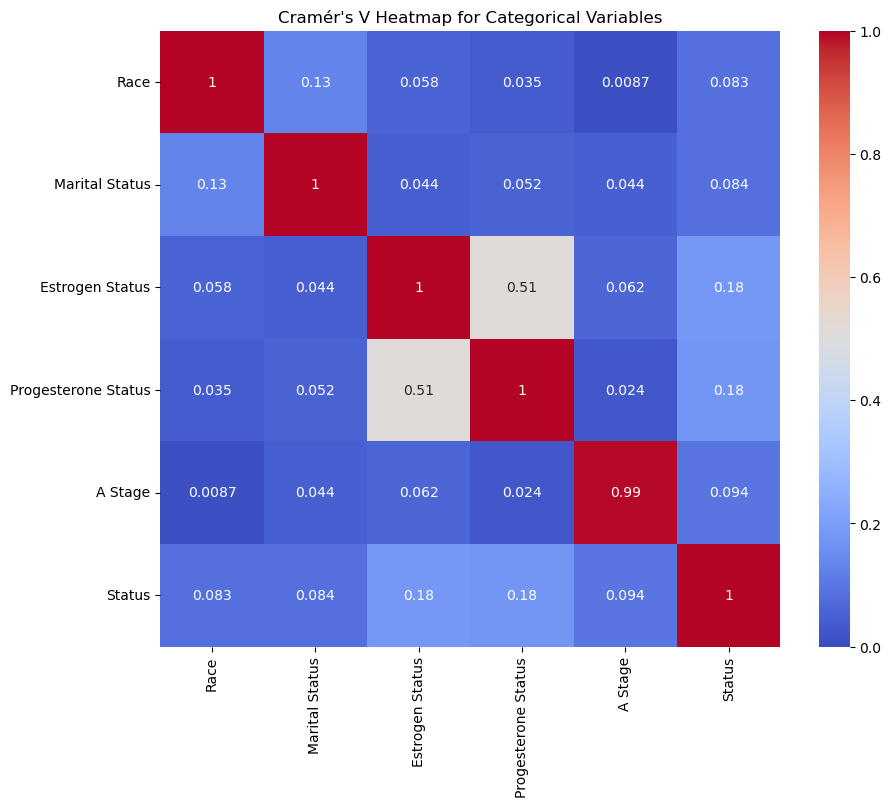

Mutual Information Scores:
Progesterone Status_Positive    0.016919
Estrogen Status_Positive        0.016512
Marital Status_Separated        0.007693
Race_Other                      0.004255
A Stage_Regional                0.003108
Race_White                      0.000000
Marital Status_Married          0.000000
Marital Status_Single           0.000000
Marital Status_Widowed          0.000000
dtype: float64


In [144]:
# Cramér's V calculation
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

categorical_features = ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status', 'A Stage', 'Status']

cramers_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features, dtype=float)

for var1 in categorical_features:
    for var2 in categorical_features:
        cramers_matrix.loc[var1, var2] = cramers_v(df_breast_cancer[var1], df_breast_cancer[var2])

# Heatmap of Cramér's V
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramér's V Heatmap for Categorical Variables")
plot_path = os.path.join(os.pardir, 'plots', 'cramerV_matrix.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

np.random.seed(14)
# Mutual Information calculation
df_cat = df_breast_cancer[categorical_features].drop(columns=['Status'])
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)  # One-hot encode non-binary variables
mi_scores = mutual_info_classif(df_cat_encoded, df_breast_cancer['Status'])
mi_scores = pd.Series(mi_scores, index=df_cat_encoded.columns)
print("Mutual Information Scores:")
print(mi_scores.sort_values(ascending=False))

### PCA

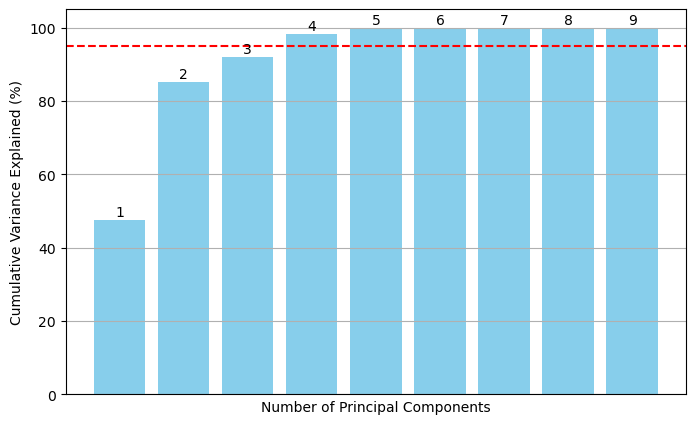

In [ ]:

pca = PCA()
pca_result = pca.fit_transform(df_breast_cancer[num_cols].drop(columns=['Status']))

cumulative_variance = np.cumsum(pca.explained_variance_ratio_ * 100)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color='skyblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')
# plt.title('Scree Plot: Cumulative Variance Explained by Principal Components')
plt.grid(axis='y')
plt.xticks([])
plt.axhline(y=95, color='r', linestyle='--')
for i, var in enumerate(cumulative_variance):
    plt.text(i + 1, var + 1, str(i + 1), ha='center')
# plot_path = os.path.join(os.pardir, 'plots', 'cum_var.png')
# plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

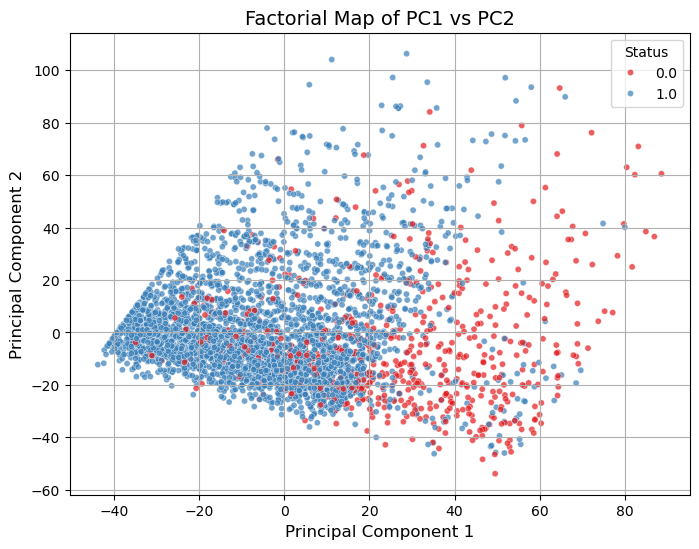

In [ ]:
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])
pca_df['Status'] = df_breast_cancer['Status']

# Plot the factorial map (PC1 vs PC2) with 'Status' as the hue
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Status', data=pca_df, palette='Set1', s=20, alpha=0.7)
plt.title('Factorial Map of PC1 vs PC2', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Status')
plt.grid(True)
# plot_path = os.path.join(os.pardir, 'plots', 'fact_scatterplot.png')
# plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

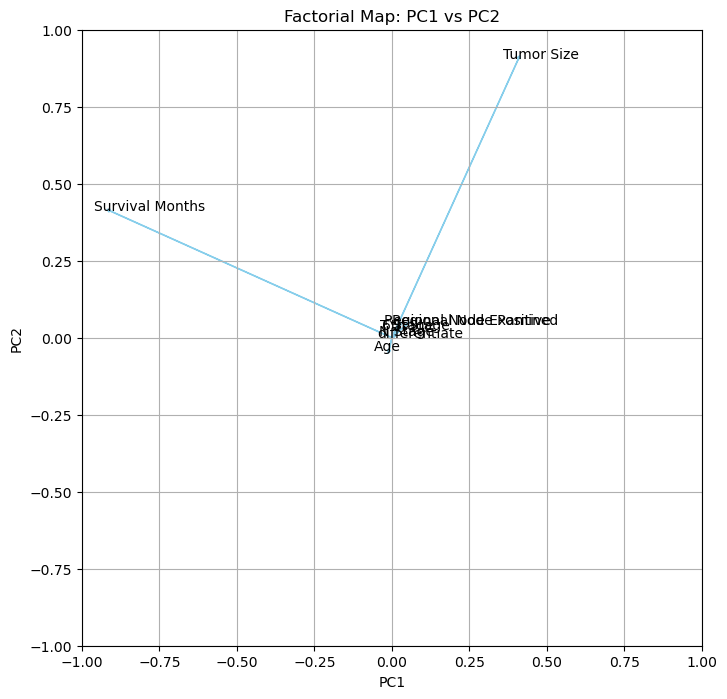

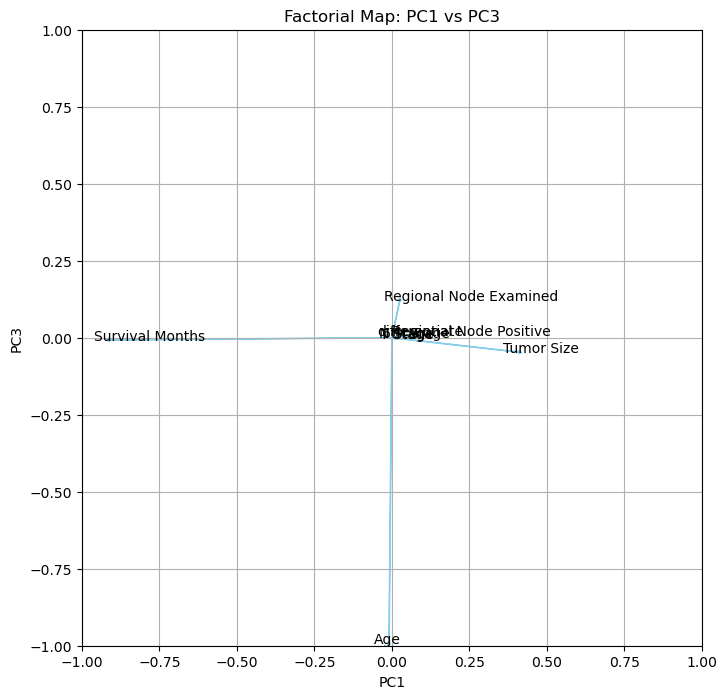

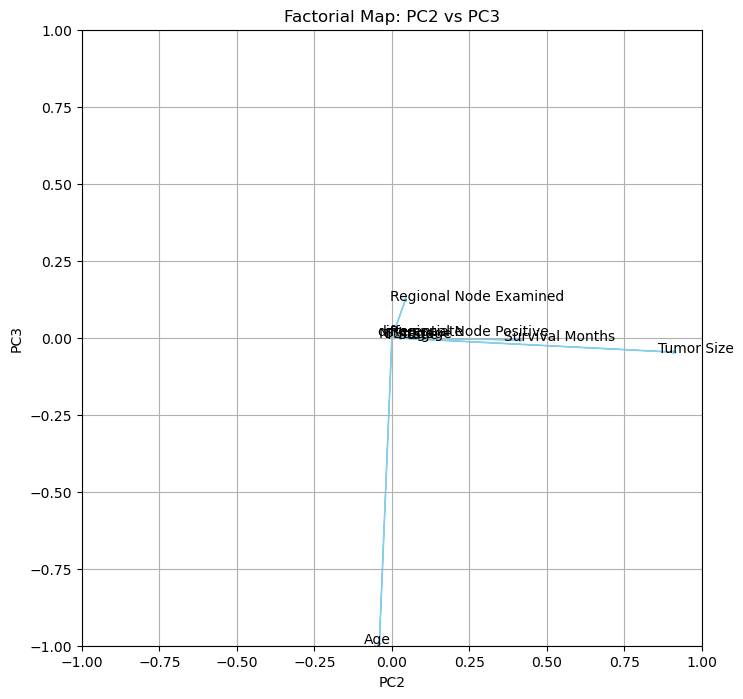

In [ ]:
# Plot factorial map with variable arrows for a given PC
def plot_factorial_map_with_arrows(pc1_index, pc2_index):
  plt.figure(figsize=(8, 8))

  for i, var in enumerate(df_breast_cancer[num_cols].drop(columns=['Status']).columns):
    plt.arrow(0, 0, pca.components_[pc1_index, i], pca.components_[pc2_index, i],
              head_width=0.01, head_length=0.01, color='skyblue')
    plt.text(pca.components_[pc1_index, i] - 0.05, pca.components_[pc2_index, i], var, fontsize=10, color='black', ha='left')

  plt.xlim(-1, 1)
  plt.ylim(-1, 1)

  plt.xlabel(f'PC{pc1_index + 1}')
  plt.ylabel(f'PC{pc2_index + 1}')
  plt.title(f'Factorial Map: PC{pc1_index + 1} vs PC{pc2_index + 1}')
  plt.grid(True)
  plt.show()

plot_factorial_map_with_arrows(0, 1)  # PC1 vs PC2
plot_factorial_map_with_arrows(0, 2)  # PC1 vs PC3
plot_factorial_map_with_arrows(1, 2)  # PC2 vs PC3